In [1]:
from   zipfile  import  ZipFile  as  zf 
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib.patches import Patch

In [ ]:
# load data

with  zf('data/Public_Schools.zip','r')  as  fp: 
    fp.extractall('data')


schools = gpd.read_file('data/Public_Schools/PublicSchools.shp')

# Keep only needed columns
schools_filtered = schools[['STATE','LEVEL_','FT_TEACHER', 'ENROLLMENT']]


# Create state abbreviation mapping (US_State uses full names, Public_Schools use abbreviations)
state_abbrev_map = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
    'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH',
    'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY',
    'District of Columbia': 'DC', 'Puerto Rico': 'PR'
}

# Load US State shapefile
us_states = gpd.read_file('data/US_State.shp')

us_states['STATE'] = us_states['StateName'].map(state_abbrev_map)

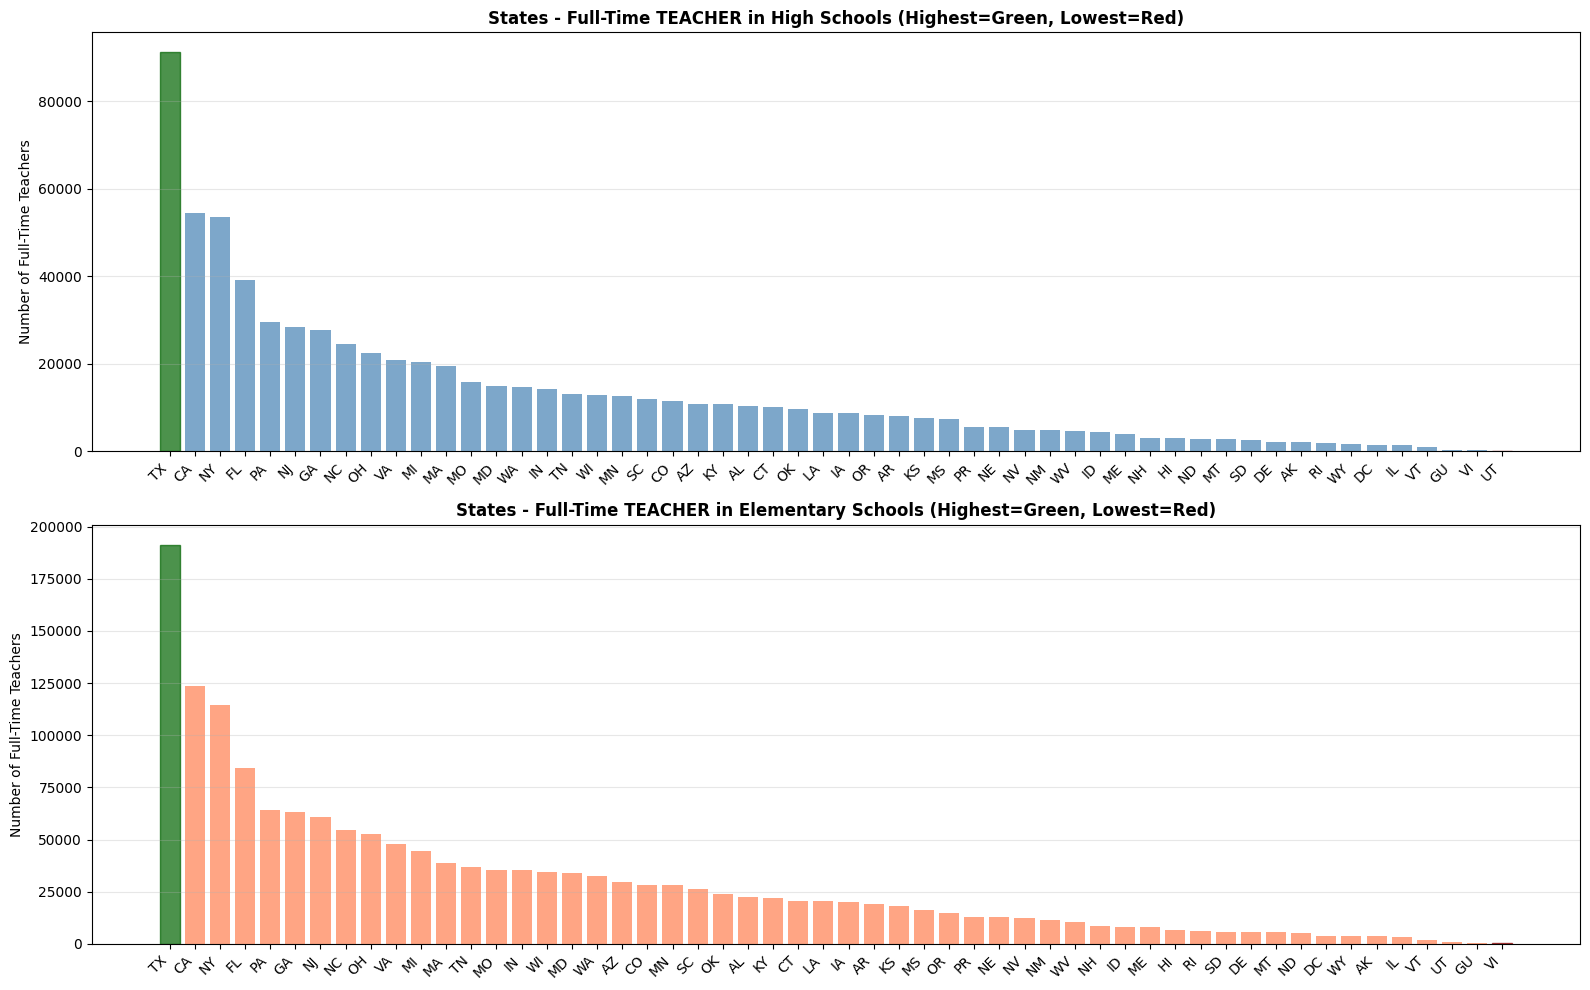

In [3]:

# Filter for High and Elementary schools
schools_filtered = schools_filtered[schools_filtered['LEVEL_'].isin(['HIGH', 'ELEMENTARY'])]

# Remove invalid FT_TEACHER values (-999 = missing data)
schools_filtered = schools_filtered[schools_filtered['FT_TEACHER'] > 0]

# Separate data by school level
high_schools = schools_filtered[schools_filtered['LEVEL_'] == 'HIGH']
elementary_schools = schools_filtered[schools_filtered['LEVEL_'] == 'ELEMENTARY']

# Calculate summary statistics per state
high_stats = high_schools.groupby('STATE')['FT_TEACHER'].agg(['mean', 'median', 'sum', 'count']).reset_index()
elem_stats = elementary_schools.groupby('STATE')['FT_TEACHER'].agg(['mean', 'median', 'sum', 'count']).reset_index()

# Create visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Sort by mean FT_TEACHER  head() can be used to limit to top 20 if needed
high_stats_sorted = high_stats.sort_values('sum', ascending=False)
elem_stats_sorted = elem_stats.sort_values('sum', ascending=False)

# Plot High Schools
x_pos = np.arange(len(high_stats_sorted))
bars1 = ax1.bar(x_pos, high_stats_sorted['sum'], color='steelblue', alpha=0.7)

# Highlight highest and lowest
bars1[0].set_color('darkgreen')
bars1[-1].set_color('darkred')

ax1.set_xticks(x_pos)
ax1.set_xticklabels(high_stats_sorted['STATE'], rotation=45, ha='right')
ax1.set_ylabel('Number of Full-Time Teachers')
ax1.set_title('States - Full-Time TEACHER in High Schools (Highest=Green, Lowest=Red)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')



# Plot Elementary Schools
x_pos2 = np.arange(len(elem_stats_sorted))
bars2 = ax2.bar(x_pos2, elem_stats_sorted['sum'], color='coral', alpha=0.7)
# Highlight highest and lowest
bars2[0].set_color('darkgreen')
bars2[-1].set_color('darkred')

ax2.set_xticks(x_pos2)
ax2.set_xticklabels(elem_stats_sorted['STATE'], rotation=45, ha='right')
ax2.set_ylabel('Number of Full-Time Teachers')
ax2.set_title('States - Full-Time TEACHER in Elementary Schools (Highest=Green, Lowest=Red)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')


plt.tight_layout()
plt.show()

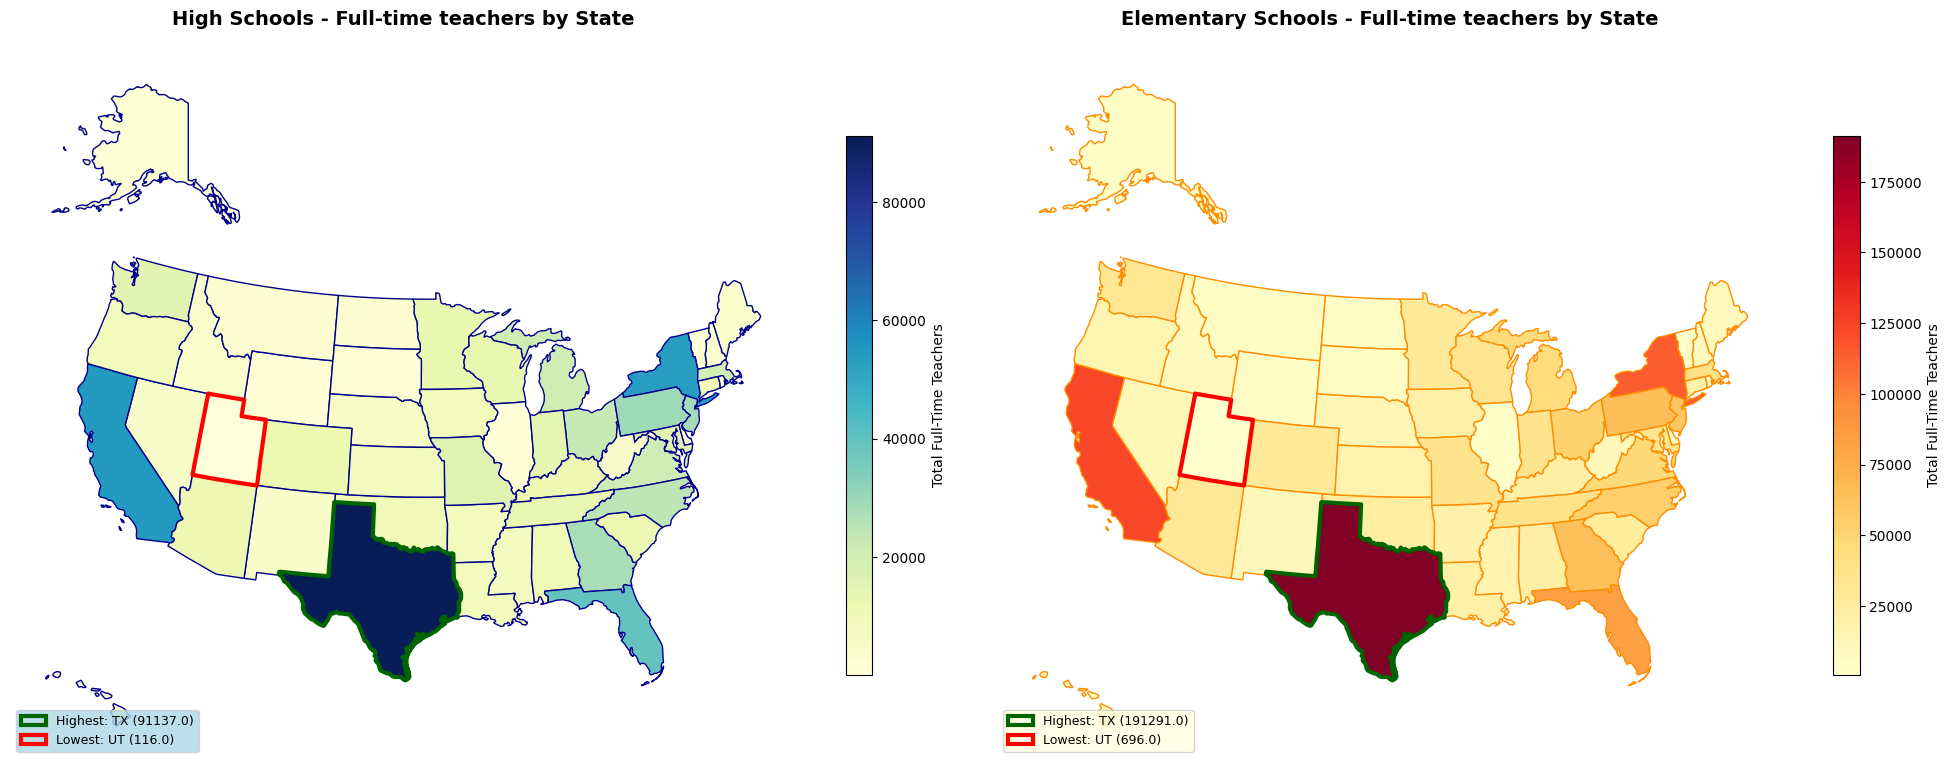

In [4]:
# Calculate TOTAL FT_TEACHER per state for each school level
high_stats_map = high_schools.groupby('STATE')['FT_TEACHER'].sum().reset_index()
high_stats_map.columns = ['STATE', 'TOTAL_FT_TEACHER']

elem_stats_map = elementary_schools.groupby('STATE')['FT_TEACHER'].sum().reset_index()
elem_stats_map.columns = ['STATE', 'TOTAL_FT_TEACHER']

# Merge with statistics
high_map_data = us_states.merge(high_stats_map, on='STATE', how='left')
elem_map_data = us_states.merge(elem_stats_map, on='STATE', how='left')

# Find highest and lowest for each school level (excluding NaN values)
high_highest = high_map_data.loc[high_map_data['TOTAL_FT_TEACHER'].idxmax()]
high_lowest = high_map_data.loc[high_map_data['TOTAL_FT_TEACHER'].idxmin()]

elem_highest = elem_map_data.loc[elem_map_data['TOTAL_FT_TEACHER'].idxmax()]
elem_lowest = elem_map_data.loc[elem_map_data['TOTAL_FT_TEACHER'].idxmin()]

# Create figure with 2 maps side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot HIGH SCHOOLS map
high_map_data.plot(
    column='TOTAL_FT_TEACHER',
    ax=ax1,
    edgecolor='darkblue',
    legend=True,
    cmap='YlGnBu',
    legend_kwds={'label': 'Total Full-Time Teachers', 'shrink': 0.7},
    vmin=high_map_data['TOTAL_FT_TEACHER'].min() - 5,
    missing_kwds={'color': 'lightgrey', 'label': 'No data'}
)

ax1.axis('off')
ax1.set_title('High Schools - Full-time teachers by State', fontsize=14, fontweight='bold', pad=20)

# Highlight highest and lowest for high schools
gpd.GeoDataFrame([high_highest]).plot(ax=ax1, facecolor='none', edgecolor='darkgreen', linewidth=3)
gpd.GeoDataFrame([high_lowest]).plot(ax=ax1, facecolor='none', edgecolor='red', linewidth=3)

# Add legend patches for high schools
high_lowest_patch = Patch(facecolor='none', edgecolor='red', linewidth=3, 
                          label=f'Lowest: {high_lowest["STATE"]} ({high_lowest["TOTAL_FT_TEACHER"]:.1f})')
high_highest_patch = Patch(facecolor='none', edgecolor='darkgreen', linewidth=3, 
                           label=f'Highest: {high_highest["STATE"]} ({high_highest["TOTAL_FT_TEACHER"]:.1f})')
leg1 = ax1.legend(handles=[high_highest_patch, high_lowest_patch], loc='lower left', fontsize=9)
leg1.get_frame().set_facecolor('lightblue')
leg1.get_frame().set_alpha(0.8)

# Plot ELEMENTARY SCHOOLS map
elem_map_data.plot(
    column='TOTAL_FT_TEACHER',
    ax=ax2,
    edgecolor='darkorange',
    legend=True,
    cmap='YlOrRd',
    legend_kwds={'label': 'Total Full-Time Teachers', 'shrink': 0.7},
    vmin=elem_map_data['TOTAL_FT_TEACHER'].min() - 3,
    missing_kwds={'color': 'lightgrey', 'label': 'No data'}
)

ax2.axis('off')
ax2.set_title('Elementary Schools - Full-time teachers by State', fontsize=14, fontweight='bold', pad=20)

# Highlight highest and lowest for elementary schools
gpd.GeoDataFrame([elem_highest]).plot(ax=ax2, facecolor='none', edgecolor='darkgreen', linewidth=3)
gpd.GeoDataFrame([elem_lowest]).plot(ax=ax2, facecolor='none', edgecolor='red', linewidth=3)

# Add legend patches for elementary schools
elem_lowest_patch = Patch(facecolor='none', edgecolor='red', linewidth=3, 
                          label=f'Lowest: {elem_lowest["STATE"]} ({elem_lowest["TOTAL_FT_TEACHER"]:.1f})')
elem_highest_patch = Patch(facecolor='none', edgecolor='darkgreen', linewidth=3, 
                           label=f'Highest: {elem_highest["STATE"]} ({elem_highest["TOTAL_FT_TEACHER"]:.1f})')
leg2 = ax2.legend(handles=[elem_highest_patch, elem_lowest_patch], loc='lower left', fontsize=9)
leg2.get_frame().set_facecolor('lightyellow')
leg2.get_frame().set_alpha(0.8)

plt.tight_layout()
plt.show()


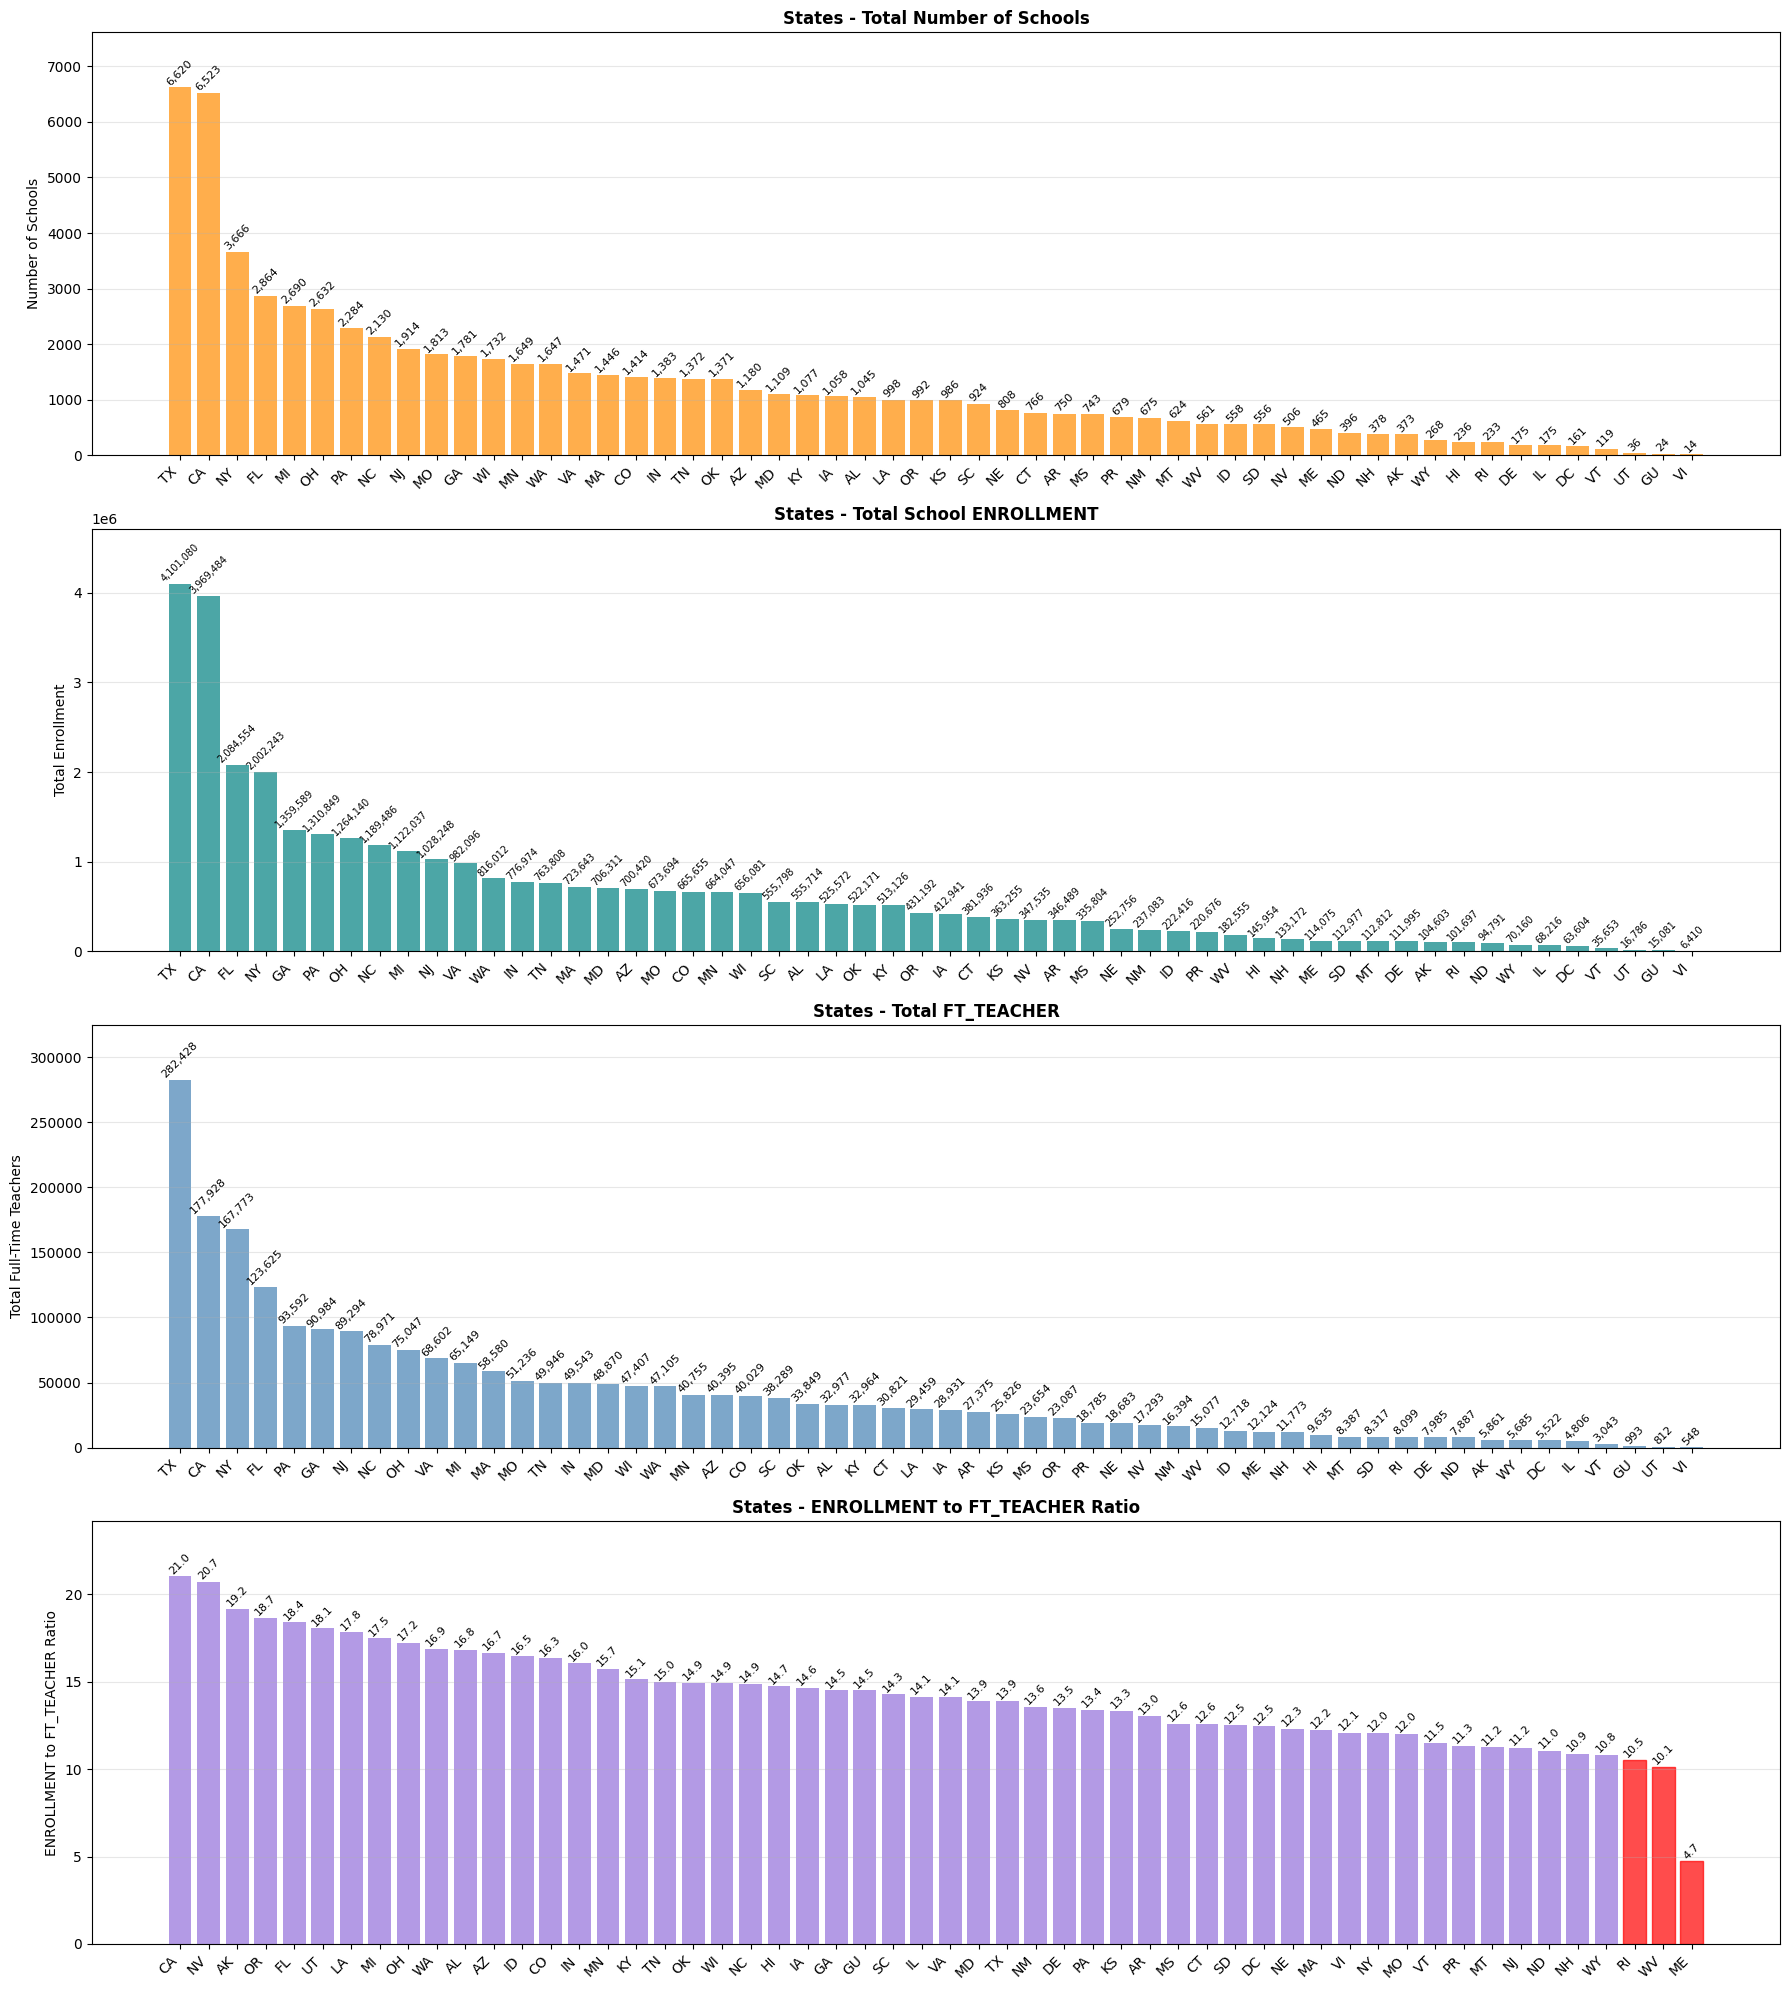

In [5]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(18, 20))

# 1. Plot the number of schools per state (unchanged)
schools_count_by_state = schools_filtered.groupby('STATE').size().reset_index(name='COUNT')
schools_count_by_state = schools_count_by_state.sort_values('COUNT', ascending=False)

x_pos1 = np.arange(len(schools_count_by_state))
bars1 = ax1.bar(x_pos1, schools_count_by_state['COUNT'], color='darkorange', alpha=0.7)
ax1.set_xticks(x_pos1)
ax1.set_xticklabels(schools_count_by_state['STATE'], rotation=45, ha='right')
ax1.set_ylabel('Number of Schools')
ax1.set_title('States - Total Number of Schools', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

for i, (idx, row) in enumerate(schools_count_by_state.iterrows()):
   ax1.text(i, row['COUNT'], f"{row['COUNT']:,}", ha='center', va='bottom', fontsize=8, rotation=45)

ax1.set_ylim(0, schools_count_by_state['COUNT'].max() * 1.15)

# 2. Plot the TOTAL ENROLLMENT per state
enrollment_by_state = schools_filtered.groupby('STATE')['ENROLLMENT'].sum().reset_index()
enrollment_by_state = enrollment_by_state.sort_values('ENROLLMENT', ascending=False)

x_pos2 = np.arange(len(enrollment_by_state))
bars2 = ax2.bar(x_pos2, enrollment_by_state['ENROLLMENT'], color='teal', alpha=0.7)
ax2.set_xticks(x_pos2)
ax2.set_xticklabels(enrollment_by_state['STATE'], rotation=45, ha='right')
ax2.set_ylabel('Total Enrollment')
ax2.set_title('States - Total School ENROLLMENT', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

for i, (idx, row) in enumerate(enrollment_by_state.iterrows()):
   ax2.text(i, row['ENROLLMENT'], f"{row['ENROLLMENT']:,.0f}", ha='center', va='bottom', fontsize=7, rotation=45)

ax2.set_ylim(0, enrollment_by_state['ENROLLMENT'].max() * 1.15)

# 3. Plot the TOTAL FT_TEACHER per state
teachers_by_state = schools_filtered.groupby('STATE')['FT_TEACHER'].sum().reset_index()
teachers_by_state = teachers_by_state.sort_values('FT_TEACHER', ascending=False)

x_pos3 = np.arange(len(teachers_by_state))
bars3 = ax3.bar(x_pos3, teachers_by_state['FT_TEACHER'], color='steelblue', alpha=0.7)
ax3.set_xticks(x_pos3)
ax3.set_xticklabels(teachers_by_state['STATE'], rotation=45, ha='right')
ax3.set_ylabel('Total Full-Time Teachers')
ax3.set_title('States - Total FT_TEACHER', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

for i, (idx, row) in enumerate(teachers_by_state.iterrows()):
   ax3.text(i, row['FT_TEACHER'], f"{row['FT_TEACHER']:,.0f}", ha='center', va='bottom', fontsize=8, rotation=45)

ax3.set_ylim(0, teachers_by_state['FT_TEACHER'].max() * 1.15)

# 4. ENROLLMENT to FT_TEACHER ratio (averaging remains correct)
schools_filtered['ENROLLMENT_FT_TEACHER_RATIO'] = schools_filtered['ENROLLMENT'] / schools_filtered['FT_TEACHER']
ratio_by_state = schools_filtered.groupby('STATE')['ENROLLMENT_FT_TEACHER_RATIO'].mean().reset_index()
ratio_by_state = ratio_by_state.sort_values('ENROLLMENT_FT_TEACHER_RATIO', ascending=False)

x_pos4 = np.arange(len(ratio_by_state))
bars4 = ax4.bar(x_pos4, ratio_by_state['ENROLLMENT_FT_TEACHER_RATIO'], color='mediumpurple', alpha=0.7)
ax4.set_xticks(x_pos4)
ax4.set_xticklabels(ratio_by_state['STATE'], rotation=45, ha='right')
ax4.set_ylabel('ENROLLMENT to FT_TEACHER Ratio')
ax4.set_title('States - ENROLLMENT to FT_TEACHER Ratio', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

for i, (idx, row) in enumerate(ratio_by_state.iterrows()):
   ax4.text(i, row['ENROLLMENT_FT_TEACHER_RATIO'], f"{row['ENROLLMENT_FT_TEACHER_RATIO']:.1f}", 
            ha='center', va='bottom', fontsize=8, rotation=45)

ax4.set_ylim(0, ratio_by_state['ENROLLMENT_FT_TEACHER_RATIO'].max() * 1.15)

# Highlight lowest 3 ratios
bars4[-1].set_color('red')
bars4[-2].set_color('red')
bars4[-3].set_color('red')

plt.tight_layout()
plt.show()



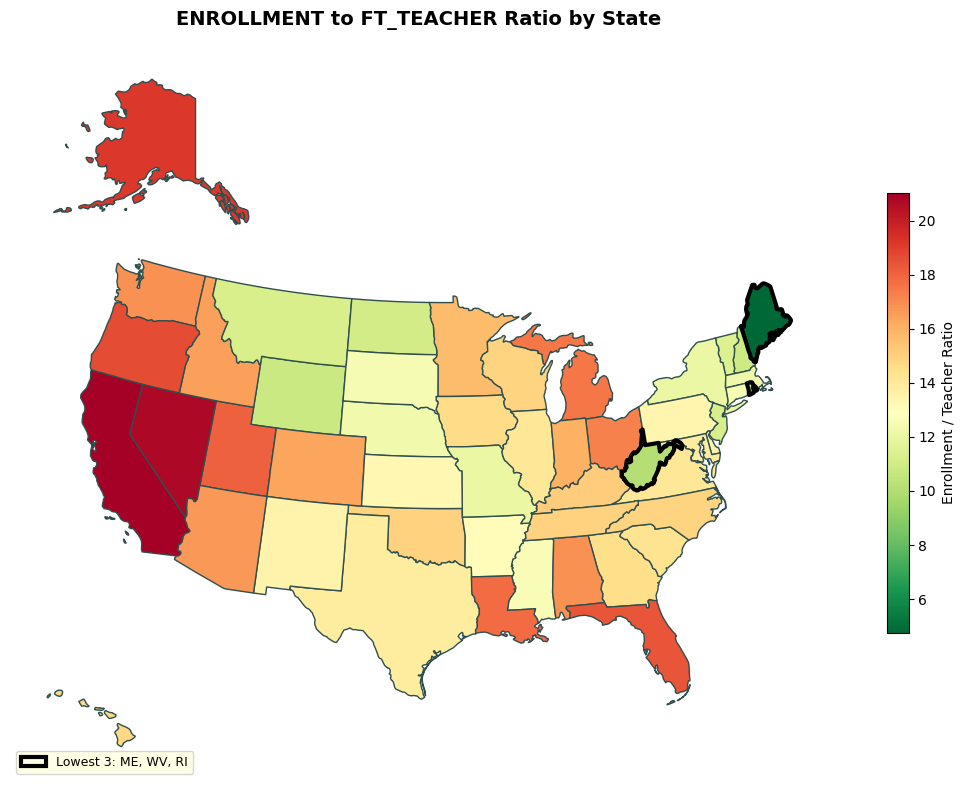

In [6]:
# Calculate RATIO per state
ratio_map = schools_filtered.groupby('STATE')['ENROLLMENT_FT_TEACHER_RATIO'].mean().reset_index()
ratio_map.columns = ['STATE', 'Total_RATIO']

# Merge with geometries
ratio_map_data = us_states.merge(ratio_map, on='STATE', how='left')

# Find lowest 3 ratios
ratio_lowest = ratio_map_data.nsmallest(1, 'Total_RATIO').iloc[0]
ratio_second_lowest = ratio_map_data.nsmallest(2, 'Total_RATIO').iloc[1]
ratio_third_lowest = ratio_map_data.nsmallest(3, 'Total_RATIO').iloc[2]

# Create single map figure
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Ratio map
ratio_map_data.plot(
    column='Total_RATIO',
    ax=ax,
    edgecolor='darkslategray',
    legend=True,
    cmap='RdYlGn_r',
    legend_kwds={'label': 'Enrollment / Teacher Ratio', 'shrink': 0.6},
    missing_kwds={'color': 'lightgrey', 'label': 'No data'}
)

ax.axis('off')
ax.set_title('ENROLLMENT to FT_TEACHER Ratio by State',
             fontsize=14, fontweight='bold', pad=15)

# Highlight lowest 3 states
gpd.GeoDataFrame([ratio_lowest]).plot(ax=ax, facecolor='none', edgecolor='black', linewidth=3)
gpd.GeoDataFrame([ratio_second_lowest]).plot(ax=ax, facecolor='none', edgecolor='black', linewidth=3)
gpd.GeoDataFrame([ratio_third_lowest]).plot(ax=ax, facecolor='none', edgecolor='black', linewidth=3)

# Legend entry for highlighted states
lowest_patch = Patch(
    facecolor='none',
    edgecolor='black',
    linewidth=3,
    label=f"Lowest 3: {ratio_lowest['STATE']}, {ratio_second_lowest['STATE']}, {ratio_third_lowest['STATE']}"
)

leg = ax.legend(handles=[lowest_patch], loc='lower left', fontsize=9)
leg.get_frame().set_facecolor('lightyellow')
leg.get_frame().set_alpha(0.8)

plt.tight_layout()
plt.show()
